# Рекомендация тарифов

Компания "Мегалайн" предоставила данные о поведении клиентов, использующих тарифы сотовой связи данной компании.

Необходимо построить модель для задачи классификации, которая выберет подходящий тариф.

**Структура данных:**

* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [16]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

pd.options.mode.chained_assignment = None 

## Открытие и изучение данных

In [17]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
df.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [19]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


## Разбиение данных на три выборки: обучающая, валидационная и тестовая


60% «Обучающая выборка» — это набор данных, который используется для разработки модели машинного обучения.

20% «Валидационная выборка» — это набор данных, который используется в процессе разработки модели машинного обучения для подбора оптимального набора гиперпараметров.

20% «Тестовая выборка» — это набор данных, который не используется непосредственно в процессе обучения модели или для подбора гиперпараметров, однако позволяет протестировать модель и является контрольным.

In [20]:
features = df.drop(['is_ultra'], axis=1)
target= df['is_ultra']

features_train, features_other, target_train, target_other = train_test_split(
    features, target, test_size=0.4, random_state=12345) 

features_test, features_valid, target_test, target_valid = train_test_split(
    features_other, target_other, test_size=0.5, random_state=12345) 

print('Размер тренерующей выборки -', features_train.shape[0])
print('Размер валидационной выборки -', features_valid.shape[0])
print('Размер тестовой выборки -', features_test.shape[0])

Размер тренерующей выборки - 1928
Размер валидационной выборки - 643
Размер тестовой выборки - 643


In [21]:
strat_piv= df.groupby('is_ultra')['is_ultra'].agg(['count'])

strat_piv['%']=(strat_piv['count']*100/3214).round(2)
strat_piv


,count,%
is_ultra,,
0,2229,69.35
1,985,30.65


## Исследование модели

Так как целью исследования стоит предсказать какой тариф предложить пользователю - "Ультра" или "Смарт"- это задача классификации

### Дерево решений

In [22]:
accurancy_num=[]
for depth in range(1,11):
    model = DecisionTreeClassifier(max_depth=depth,random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy=accuracy_score(target_valid, predictions_valid).round(4)
    accurancy_num.append(accuracy)
    print("max_depth =", depth, ": ", end='')
    print(accuracy)

max_depth = 1 : 0.7356
max_depth = 2 : 0.7745
max_depth = 3 : 0.7792
max_depth = 4 : 0.7745
max_depth = 5 : 0.7838
max_depth = 6 : 0.776
max_depth = 7 : 0.7994
max_depth = 8 : 0.7932
max_depth = 9 : 0.7807
max_depth = 10 : 0.7885


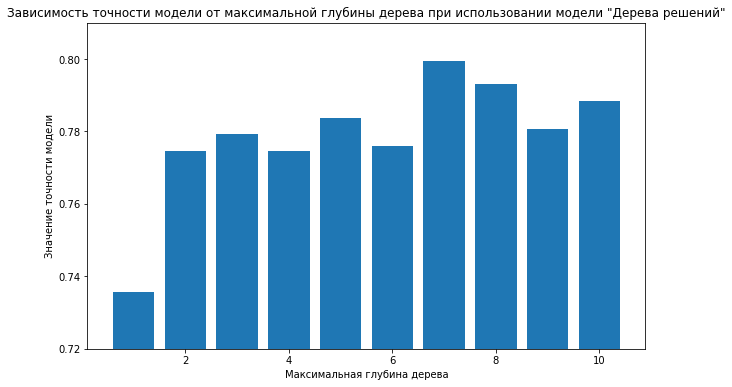

In [23]:
# построение гистограмы для наглядного отображения зависимость точности модели от 
# максимальной глубины дерева при использовании модели "Дерева решений"
x=range(1,11)
y=accurancy_num
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x, y)

ax.set_title('Зависимость точности модели от максимальной глубины дерева при использовании модели "Дерева решений"')
ax.set_xlabel('Максимальная глубина дерева')
ax.set_ylabel('Значение точности модели')

ax.set_ylim([0.72, 0.81]);

In [24]:
accurancy_num_val=[]
accurancy_num_train=[]
for depth in range(1,26):
    model = DecisionTreeClassifier(max_depth=depth,random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    predictions_train = model.predict(features_train)
    accuracy_val=accuracy_score(target_valid, predictions_valid).round(4)
    accuracy_train=accuracy_score(target_train, predictions_train).round(4)
    
    accurancy_num_val.append(accuracy_val)
    accurancy_num_train.append(accuracy_train)


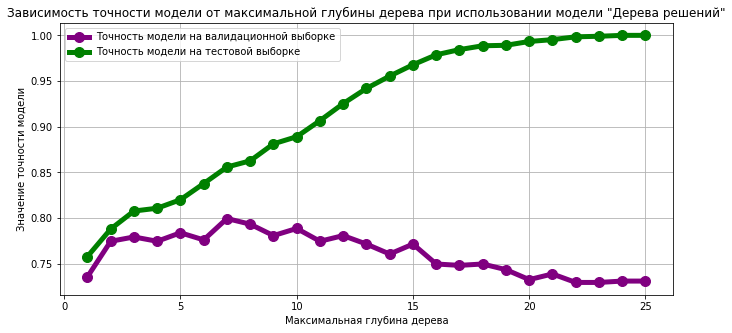

In [25]:
x=range(1,26)
y=accurancy_num_val
z=accurancy_num_train
plt.subplots(figsize=(11,5)) 
plt.title('Зависимость точности модели от максимальной глубины дерева при использовании модели "Дерева решений"')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Значение точности модели')
plt.plot(x,y,label='Точность модели на валидационной выборке',linewidth=5,marker='o',ms = 10,c='purple')
plt.plot(x,z,label='Точность модели на тестовой выборке', linewidth=5,marker='o',ms = 10,c='green')
plt.grid() 
plt.legend()
plt.show()


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
При использовании данного графика была обнаружена интересная зависимость - при увеличении глубины ветвления точность на обучающей выборке стремиться к 1, а валидационной выборки к 0
    </div>

In [26]:
best_accuracy = 0
best_depth = 0
for depth in range(1,16):
    model2 = DecisionTreeClassifier(max_depth=depth, random_state=12345, criterion="entropy", splitter='best')
    model2.fit(features_train, target_train)
    predictions_valid = model2.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth
print("Лучшие показатели дерева решений:")
print("Глубина дерева -", best_depth) 
print("Качество модели -", best_accuracy.round(4))

Лучшие показатели дерева решений:
Глубина дерева - 8
Качество модели - 0.8009


In [27]:
# вывод лучшей модели

best_tree_model = DecisionTreeClassifier(max_depth=8, random_state=12345, criterion="entropy", splitter='best')
best_tree_model.fit(features_train, target_train)
predictions_valid = best_tree_model.predict(features_valid)
print(confusion_matrix(target_valid, predictions_valid))
print(classification_report(target_valid, predictions_valid))

[[410  30]
 [ 98 105]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       440
           1       0.78      0.52      0.62       203

    accuracy                           0.80       643
   macro avg       0.79      0.72      0.74       643
weighted avg       0.80      0.80      0.79       643



* True Positive (TP) = 410; это означает, что 410 положительных точек данных были правильно классифицированы моделью.
* True Negative (TN) = 105; это означает, что 105 отрицательных точек данных были правильно классифицированы моделью.
* False Positive (FP) = 30; это означает, что 30 отрицательных точек данных были неправильно классифицированы моделью как положительные.
* False Negative (FN) = 98; это означает, что 98 положительных точек данных были неправильно классифицированы моделью как отрицательные.

Таким образом, наибольшую точность предсказания для "Дерева решений" имеет модель с глубиной дерева - 8, качество такой модели = 0.8. Что довольно близко к 1 

Были добавлены гиперпараметры:

* criterion = функция для измерения качества разбиения. Поддерживаются критерии 'gini' для неоднородности Джини и 'entropy' для прироста информации

* splitter = стратегия, используемая для выбора разбиения в каждом узле. Поддерживаются стратегии 'best' для выбора лучшего разбиения и 'random' для выбора лучшего рандомного разбиения

При изменении в параметре splitter значения на random точность понизилась

### Случайный лес

In [28]:
best_model = 0
best_result = 0
best_depth = 0
best_est = 0
for depth in range(1,15):
    for est in range(1,51,5):
        model3 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, criterion="gini") # количество деревьев
        model3.fit(features_train,target_train) 
        result = model3.score(features_valid,target_valid) 
        if result > best_result:
            best_model = model3 
            best_result = result
            best_depth = depth
            best_est = est

print("Accuracy наилучшей модели на валидационной выборке:", best_result.round(4))
print("Глубина дерева:", best_depth)
print("Количество деревьев:", best_est)

Accuracy наилучшей модели на валидационной выборке: 0.8134
Глубина дерева: 9
Количество деревьев: 16


In [29]:
# вывод лучшей модели
best_forest_model = RandomForestClassifier(random_state=12345, n_estimators=16, max_depth=9, criterion="gini") # количество деревьев
best_forest_model.fit(features_train,target_train) 
result = best_forest_model.score(features_valid,target_valid) 


Таким образом, наибольшую точность предсказания для "Случайного леса" имеет модель с глубиной дерева - 9, количеством деревьев - 16, качество такой модели = 0.8134. Что еще ближе к 1, чем результат "Дерева решений"

При изменении в параметре criterion значения на entropy точность понизилась

### Логистическая регрессия

In [30]:
log_reg_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
log_reg_model.fit(features_train, target_train)

log_reg_model.predict(features_valid)
result = log_reg_model.score(features_valid,target_valid)
print("Точность модeли:", result.round(4))

Точность модeли: 0.6843


Для "Логистической регрессии" значение точности модели = 0.6843, что является самым низким значением среди примененных ранее моделей

In [31]:
resume = pd.DataFrame({'Модель': ['Дерево решений', 'Случайный лес', 'Логистическая регрессия'],
                    'Точность модели': [0.8009, 0.8134, 0.6843], 
                    'Глубина дерева':[8,9,'-'], 
                    'Количество деревьев':['-',16,'-']})\
        .set_index('Модель')
resume

,Точность модели,Глубина дерева,Количество деревьев
Модель,,,
Дерево решений,0.8009,8,-
Случайный лес,0.8134,9,16
Логистическая регрессия,0.6843,-,-


**Выводы после применения трех моделей:**

1. **Качество (accuracy)** Чем выше качество, тем больше прибыли приносит продукт.
Самое высокое качество у случайного леса: вместо одного решающего дерева используется целый лес.
На втором месте — предсказания у дерева решений. Если глубина меньше 8, оно недообучается, когда больше — переобучается.
Самое низкое качество предсказания у логистической регрессии. 
2. **Скорость работы**
Высокая скорость работы у логистической регрессии: у неё меньше всего параметров.
Скорость решающего дерева тоже высокая и зависит от глубины. В экспериментах наилучшее качество модели получилось при глубине, равной 8. Ответ на вопрос модель получила всего за 8 проверок значений признаков — а это очень быстро!
Случайный лес медленнее всех: чем больше деревьев, тем неторопливее работает модель.

## Проверьте модель на тестовой выборке

In [32]:
predictions_test = best_forest_model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_test)
print('Точность модели случайного леса на тестовой выборке -',accuracy.round(4))


Точность модели случайного леса на тестовой выборке - 0.7869


In [33]:
resume['Точность на тестовой выборке'] = [0.7776,0.7869,0.7107]
resume

,Точность модели,Глубина дерева,Количество деревьев,Точность на тестовой выборке
Модель,,,,
Дерево решений,0.8009,8,-,0.7776
Случайный лес,0.8134,9,16,0.7869
Логистическая регрессия,0.6843,-,-,0.7107


In [34]:
train_features_large = pd.concat([features_train, features_valid])
train_targets_large = pd.concat([target_train, target_valid])

best_forest_model = RandomForestClassifier(random_state=12345, n_estimators=16, max_depth=9, criterion="gini")
best_forest_model.fit(train_features_large,train_targets_large)
predictions_test = best_forest_model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_test).round(4)
print("Точность модели при обучении на train+valid выборках -", accuracy)

Точность модели при обучении на train+valid выборках - 0.8025


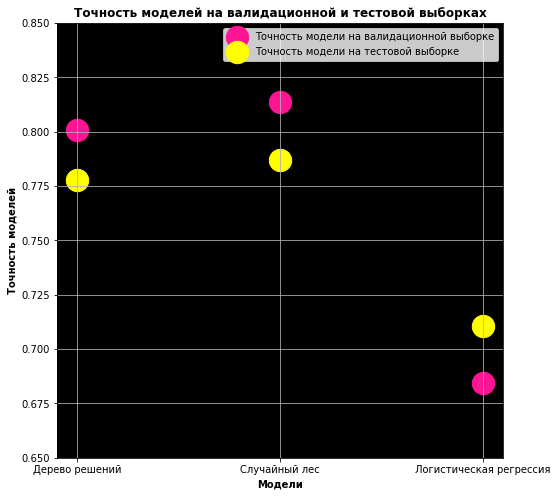

In [35]:
fig, ax  = plt.subplots(figsize=(8,8))
ax.scatter(y=resume['Точность модели'],x=resume.index,c = 'deeppink',s = 500, label='Точность модели на валидационной выборке')
ax.scatter(y=resume['Точность на тестовой выборке'],x=resume.index,c = 'yellow',s = 500,label='Точность модели на тестовой выборке')
ax.set_facecolor('black')
ax.set_ylim([0.65, 0.85])
ax.legend()
ax.set_title('Точность моделей на валидационной и тестовой выборках', weight='bold')
ax.set_xlabel('Модели', weight='bold')
ax.set_ylabel('Точность моделей', weight='bold');
plt.grid()

Таким образом, для моделей Дерева решений и Случайного леса значение точности модели на валидационной выборке выше,  это значит, что модель переобучилась. А при использовании Логистической регрессии наоборот.

Более высокие к 1 значения у модели Случайного леса

## Проверка модели на адекватность

Проверка выбранной модели Случайного леса на адекватность с помощью метрик - accuracy, precision, recall и f_score

* **Precision** (точность) показывает: сколько реальных объектов класса среди всех тех, что классификатор отнес к этому классу. Однако, у этой метрики есть явный минус - она никак не учитывает количество объектов данного класса, которые классификатор в него “забыл” включить. 

>**Precision = TP/(TP+FP)**
* **Recall** (полнота) показывает: какую долю из общих объектов класса составляют найденные объекты. Фактически, recall учитывает слабое место precision. 

>**Recall = TP/(TP+FN)**
* **Аccuracy** - делим число правильных ответов на общее число ответов классификатора. Метрика достаточно логичная, но малоинформативная. Доля ошибок не дает понятия о том, в какую сторону двигаться и какие именно ошибки совершает классификатор. 

>**Accuracy = (TP+TN)/(TP+FP+FN+TN)**
* **Specificity** - метрика показывает, насколько правильно классификатор не относит объекты к классу. 

>**Specificity = TN/(TN+FP)**
* **Fall-out, FPR (false positive rate)** - метрика показывает, насколько часто классификатор относит объекты в неверный класс. 

>**FPR = FP/(FP+TN)**
* **F1-score** - для общей оценки качества модели можно не только оценивать каждую метрику по-отдельности, но и комбинировать их. Например, показатель F1-score - это среднее гармоническое значение между precision и recall. 

>**F1 Score = 2*(Recall * Precision) / (Recall + Precision)**

In [36]:
rfm_dummy = DummyClassifier(random_state=12345, strategy='most_frequent') 

rfm_dummy.fit(features_train,target_train)
rfm_pred = rfm_dummy.predict(target_test)
accuracy3 = accuracy_score(target_test, rfm_pred).round(4)
print("Точность модели с использованием DummyClassifier -", accuracy3)
print('Уникальные значения в предсказаниях: ', (np.unique(rfm_pred)))

Точность модели с использованием DummyClassifier - 0.7061
Уникальные значения в предсказаниях:  [0]


In [37]:
confusion_matrix(target_test, rfm_pred )

array([[454,   0],
       [189,   0]])

**Параметры DummyClassifier**

strategy{“stratified”, “most_frequent”, “prior”, “uniform”, “constant”}, default=”prior”

* «stratified»: генерирует прогнозы с учетом распределения классов обучающей выборки.
* «most_frequent»: всегда предсказывает наиболее частую метку в обучающем наборе.
* «prior»: всегда предсказывает класс, который максимизирует предыдущий класс (например, «most_frequent»), а predict_proba возвращает предыдущий класс.
* «uniform»: генерирует прогнозы равномерно в случайном порядке.
* «constant»: всегда предсказывает постоянную метку, предоставленную пользователем. Это полезно для показателей, которые оценивают класс, не являющийся большинством

In [38]:
cm_theory = np.array ([['TP', 'FP'], ['FN', 'TN']])
print(cm_theory)

[['TP' 'FP']
 ['FN' 'TN']]


In [39]:
test_predictions = best_forest_model.predict(features_test)

accuracy = accuracy_score(target_test, test_predictions).round(4)
precision = precision_score(target_test, test_predictions).round(4)
recall = recall_score(target_test, test_predictions).round(4)
cm=confusion_matrix(target_test, test_predictions)
specificity = (cm[1,1]/(cm[0,1]+cm[1,1])).round(4)
FPR = (cm[0,1]/(cm[0,1]+cm[1,1])).round(4)

f_score = f1_score(target_test, test_predictions).round(4)

print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('Specificity =', specificity)
print('FPR =',FPR,'\n')
print('F-мера =', f_score, '\n')
print('Confusion matrix','\n',cm,'\n')



Accuracy = 0.8025
Precision = 0.75
Recall = 0.4921
Specificity = 0.75
FPR = 0.25 

F-мера = 0.5942 

Confusion matrix 
 [[423  31]
 [ 96  93]] 



**Вывод:**

* **Precision** - 70.6% значений от числа всех значений, отнесенных к классу Ультра, действительно относятся к классу Ультра 
* **Recall** - 47.1% значений потеряно (не отнесено к классу Ультра)
* **Аccuracy** - 78.7% значений выявлено верно
* **Specificity** - 70.6% значений верно не отнесены к классу Ультра
* **FPR** - 29.4% значений отнесены в неверный класс
* **F1-score** - 0.5651 среднее качество модели

## Общий вывод

Для предсказания какой тариф предложить клиенту была выбрана модель Случайного леса с параметрами Глубина дерева: 9, Количество деревьев: 16, точность на валидационной выборке: 0.8134

При применении на тестовой выборке значение точности снизилось до 0.7869, что означает переобучение модели. Возможно количество данных не достаточное для обучения модели (3214 наблюдений) 